# Downloading the file from the GitHub

In [1]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print(f"helper_function.py is already exists ,skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        print("Writing into file")
        f.write(request.content)

helper_function.py is already exists ,skipping download


# Make Data

In [2]:
from sklearn.datasets import make_circles
import numpy as np

# make 1000 samples
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
X.shape,y.shape

((1000, 2), (1000,))

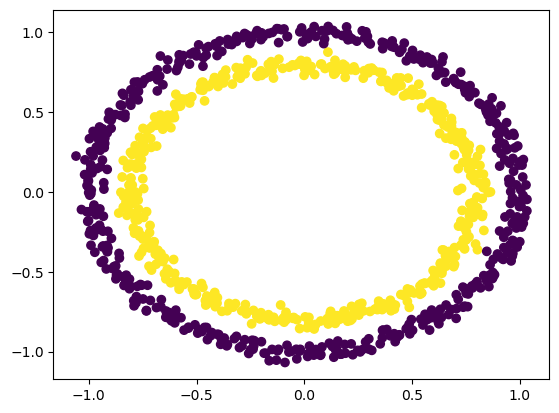

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

# Turn data into tensor

In [5]:
import torch
torch.__version__

'1.13.1'

In [6]:
X =  torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
# split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

X_train.shape,X_test.shape,y_train.shape,y_train.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([800]))

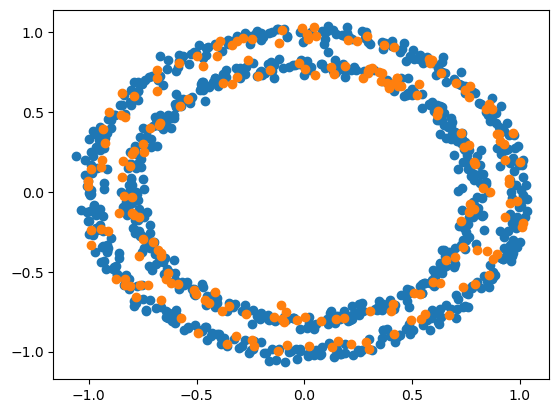

In [8]:
plt.scatter(X_train[:,0],X_train[:,1])
plt.scatter(X_test[:,0],X_test[:,1])
plt.show()

# Building the model

1. Setup device agnostic
2. Construct the model using the nn.Module
3. Pick the loss function
4. Pick the optimiser
5. Create the training and test loop

In [9]:
import torch
from torch import nn

## Device agnostic


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Construct the model

1. Subclass the nn.Module
2. Create 2 Layer
3. Define the forward pass
4. Instance the model class and send to target device

In [11]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer_2(self.layer_1(x))

In [12]:
model_0 = MLPBinaryClassifier()
model_0.to(device)

MLPBinaryClassifier(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4183, -0.5528],
                      [ 0.6634, -0.3805],
                      [-0.3879,  0.5668],
                      [ 0.3679,  0.3895],
                      [-0.4184, -0.4580]])),
             ('layer_1.bias',
              tensor([-0.5061, -0.6463, -0.4087,  0.4826, -0.2443])),
             ('layer_2.weight',
              tensor([[ 0.1438,  0.0501,  0.0262, -0.1885, -0.1622]])),
             ('layer_2.bias', tensor([0.0806]))])

In [14]:
# replicate model using the nn.Sequential
model_seq_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_seq_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_seq_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2159, -0.4091],
                      [ 0.4936,  0.2207],
                      [ 0.0044,  0.1457],
                      [-0.6220, -0.7050],
                      [ 0.2953, -0.0972]])),
             ('0.bias', tensor([-0.5967, -0.2278,  0.0239, -0.4051, -0.3954])),
             ('1.weight',
              tensor([[ 0.2941,  0.2846,  0.3729, -0.2020, -0.3037]])),
             ('1.bias', tensor([0.3529]))])

## Set loss and optimizer

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
#? this combine the sigmoid layer and the Binary Cross Entropy into the one layer , so that it increase the numerical stability.

optimizer = torch.optim.SGD(params=model_seq_0.parameters(),
                            lr=0.1)

In [17]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

## Training the model

1. loop the data
2. Forward pass
3. calculate the loss
4. zero grad optimizer
5. loss backward
6. optimizer step

### Going from raw logit -> predication probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

we can convert these logit into prediction probabilities by passing them to some kind of activation function
* sigmoid for the binary classification.
* softmax for the multiclass classification.


In [18]:
#? these output are logit since we didn't pass the activation function
model_seq_0.eval()
with torch.inference_mode():
    y_logits = model_seq_0(X_test.to(device))[:5]
y_logits

tensor([[0.3480],
        [0.4892],
        [0.1005],
        [0.4176],
        [0.2951]])

In [19]:
y_test[:5]
# we need to compare these with logit , so we need to convert them prediction probability.

tensor([1., 0., 1., 0., 1.])

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5861],
        [0.6199],
        [0.5251],
        [0.6029],
        [0.5732]])

In [21]:
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

## Build the training loops

In [22]:
epochs = 1000

# put the data to device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

# 1. loop the data
for epoch in range(epochs):
    # put the model in training loop
    model_seq_0.train()
    # 2. forward pass
    y_logits = model_seq_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 3. calculate the loss
    # since we used the BCEwithLogitLoss, so we need to pass the logits
    loss = loss_fn(y_logits,y_train)

    # # if we use the only we BCEloss , so we need to pass the y_pred that pass to sigmoid
    # loss = nn.BCELoss()(torch.sigmoid(y_logits),y_train)

    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

    # 4. optimise the zero grad
    optimizer.zero_grad()

    # 5. backward the loss
    loss.backward()

    # 6. optimizer step
    optimizer.step()

    ### Testing
    model_seq_0.eval()
    with torch.inference_mode():
        #1.. forward pass
        test_logits = model_seq_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the test logit
        test_loss = loss_fn(test_logits,y_test)

        test_acc =  accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

    if epoch % 10 ==0 :
        print(f"Epoch : {epoch} | Loss: {loss:.5f} | Acc : {acc:.2f}% | TestLoss : {test_loss:.6f} | Test Acc :{test_acc:.2f}%")

Epoch : 0 | Loss: 0.70870 | Acc : 50.00% | TestLoss : 0.716020 | Test Acc :50.00%
Epoch : 10 | Loss: 0.69938 | Acc : 56.38% | TestLoss : 0.705332 | Test Acc :50.50%
Epoch : 20 | Loss: 0.69605 | Acc : 53.25% | TestLoss : 0.700945 | Test Acc :49.50%
Epoch : 30 | Loss: 0.69476 | Acc : 52.38% | TestLoss : 0.698877 | Test Acc :47.50%
Epoch : 40 | Loss: 0.69419 | Acc : 51.50% | TestLoss : 0.697727 | Test Acc :47.50%
Epoch : 50 | Loss: 0.69388 | Acc : 51.38% | TestLoss : 0.696988 | Test Acc :47.50%
Epoch : 60 | Loss: 0.69369 | Acc : 51.62% | TestLoss : 0.696463 | Test Acc :48.50%
Epoch : 70 | Loss: 0.69355 | Acc : 51.38% | TestLoss : 0.696067 | Test Acc :48.50%
Epoch : 80 | Loss: 0.69344 | Acc : 51.25% | TestLoss : 0.695759 | Test Acc :48.50%
Epoch : 90 | Loss: 0.69336 | Acc : 51.12% | TestLoss : 0.695513 | Test Acc :48.50%
Epoch : 100 | Loss: 0.69330 | Acc : 51.00% | TestLoss : 0.695317 | Test Acc :48.50%
Epoch : 110 | Loss: 0.69325 | Acc : 51.12% | TestLoss : 0.695158 | Test Acc :48.00%
Epo

Since we are using only the linear function our model , is just guess of coin toss.

In [23]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

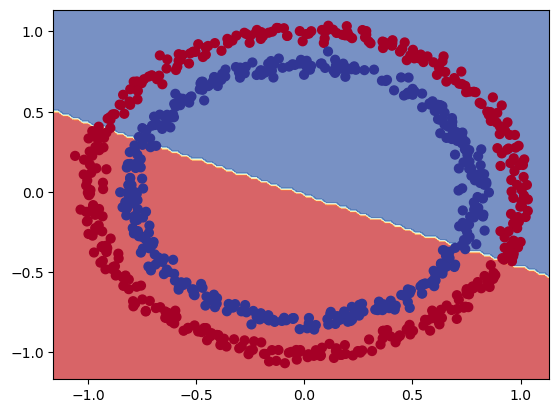

In [24]:
plot_decision_boundary(model_seq_0,X_train,y_train)

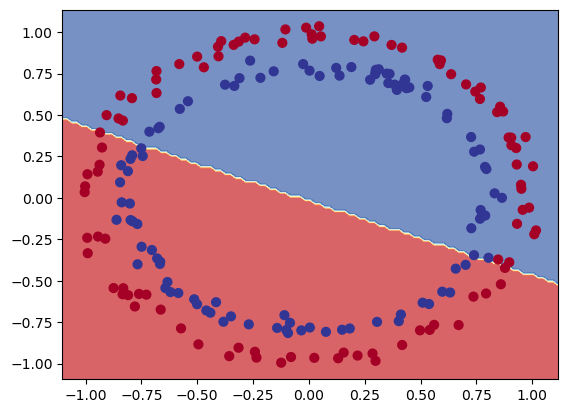

In [25]:
plot_decision_boundary(model_seq_0,X_test,y_test)

## Improve the model

1. Add more layer - give the model more change to learn about the pattern in the data.
2. Add more hidden units
3. Fit for longer
4. Change the activation functions
5. Change teh learning rate ,
6. Change the loss functions

Lets try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs : 100 -> 1000

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [27]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
# create the loss function
loss_fn = nn.BCEWithLogitsLoss()
# create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [29]:
### training  loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# increase the number of epoch
epochs = 1000

# put the data into device
X_train ,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    #### Training
    model_1.train()
    # 1. forward the pass
    y_logits = model_1(X_train).squeeze()
    y_pred  = torch.round((torch.sigmoid(y_logits)))
    # 2. calculate the loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. optimizer step
    optimizer.step()
    #### Testing mode
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if (epoch+1)%10 ==0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f} | Acc : {acc:.2f}% | TestLoss : {test_loss:.6f} | Test Acc :{test_acc:.2f}%")

Epoch : 9 | Loss: 0.69594 | Acc : 56.50% | TestLoss : 0.694518 | Test Acc :54.50%
Epoch : 19 | Loss: 0.69484 | Acc : 51.12% | TestLoss : 0.693805 | Test Acc :55.50%
Epoch : 29 | Loss: 0.69443 | Acc : 49.62% | TestLoss : 0.693660 | Test Acc :56.50%
Epoch : 39 | Loss: 0.69421 | Acc : 50.12% | TestLoss : 0.693669 | Test Acc :53.50%
Epoch : 49 | Loss: 0.69407 | Acc : 50.12% | TestLoss : 0.693719 | Test Acc :51.50%
Epoch : 59 | Loss: 0.69395 | Acc : 49.50% | TestLoss : 0.693780 | Test Acc :53.50%
Epoch : 69 | Loss: 0.69386 | Acc : 49.50% | TestLoss : 0.693844 | Test Acc :54.50%
Epoch : 79 | Loss: 0.69378 | Acc : 49.50% | TestLoss : 0.693906 | Test Acc :55.50%
Epoch : 89 | Loss: 0.69371 | Acc : 49.25% | TestLoss : 0.693966 | Test Acc :53.50%
Epoch : 99 | Loss: 0.69364 | Acc : 49.88% | TestLoss : 0.694024 | Test Acc :53.50%
Epoch : 109 | Loss: 0.69359 | Acc : 49.75% | TestLoss : 0.694078 | Test Acc :53.50%
Epoch : 119 | Loss: 0.69354 | Acc : 49.50% | TestLoss : 0.694130 | Test Acc :53.00%
Epo

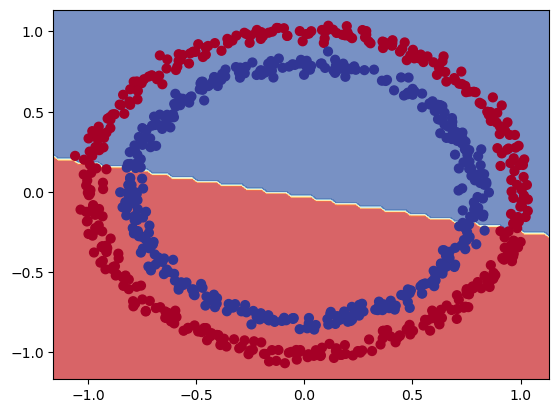

In [30]:
plot_decision_boundary(model_1,X_train,y_train)

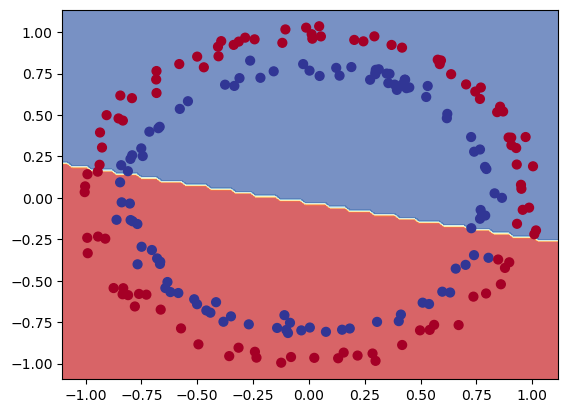

In [31]:
plot_decision_boundary(model_1,X_test,y_test)

# Thinking what happening inside the gradient

In [38]:
weight = 0.7
bias = 0.3

X_reg = torch.linspace(0.,1.,50).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

X_reg.shape,y_reg.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [65]:
model_linear = nn.Sequential(
    nn.Linear(in_features=1,out_features=1)
)

In [40]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_linear.parameters(),
                            lr=0.01)

In [41]:
for epoch in range(2):
    model_linear.train()
    y_pred = model_linear(X_reg)
    loss = loss_fn(y_pred,y_reg)
    loss.retain_grad()
    print("Before Setting the grad to zero:")
    print(f"\t loss : {loss.grad},{loss.data}")
    for name,param in model_linear.named_parameters():
        print(f"\t{name} : {param.grad} {param.data}")
    optimizer.zero_grad()
    print("After Setting the grad to zero:")
    print(f"\t loss : {loss.grad},{loss.data}")
    for name,param in model_linear.named_parameters():
        print(f"\t{name} : {param.grad} {param.data}")
    loss.backward()
    print("After the back propagate")
    print(f"\t loss : {loss.grad},{loss.data}")
    for name,param in model_linear.named_parameters():
        print(f"\t{name} : {param.grad} {param.data}")
    optimizer.step()
    print("After updating the step")
    print(f"\t loss : {loss.grad},{loss.data}")
    for name,param in model_linear.named_parameters():
        print(f"\t{name} : {param.grad} {param.data}")

Before Setting the grad to zero:
	 loss : None,0.5622771382331848
	0.weight : None tensor([[0.7645]])
	0.bias : None tensor([0.8300])
After Setting the grad to zero:
	 loss : None,0.5622771382331848
	0.weight : None tensor([[0.7645]])
	0.bias : None tensor([0.8300])
After the back propagate
	 loss : 1.0,0.5622771382331848
	0.weight : tensor([[0.5000]]) tensor([[0.7645]])
	0.bias : tensor([1.]) tensor([0.8300])
After updating the step
	 loss : 1.0,0.5622771382331848
	0.weight : tensor([[0.5000]]) tensor([[0.7595]])
	0.bias : tensor([1.]) tensor([0.8200])
Before Setting the grad to zero:
	 loss : None,0.5497772097587585
	0.weight : tensor([[0.5000]]) tensor([[0.7595]])
	0.bias : tensor([1.]) tensor([0.8200])
After Setting the grad to zero:
	 loss : None,0.5497772097587585
	0.weight : tensor([[0.]]) tensor([[0.7595]])
	0.bias : tensor([0.]) tensor([0.8200])
After the back propagate
	 loss : 1.0,0.5497772097587585
	0.weight : tensor([[0.5000]]) tensor([[0.7595]])
	0.bias : tensor([1.]) ten

In [42]:
list(model_linear.named_parameters())[0][0]

'0.weight'

In [43]:
list(model_linear.parameters())

[Parameter containing:
 tensor([[0.7545]], requires_grad=True),
 Parameter containing:
 tensor([0.8100], requires_grad=True)]

In [44]:
for epoch in range(2):
    model_linear.train()
    y_pred = model_linear(X_reg)
    loss = loss_fn(y_pred,y_reg)
    loss.retain_grad()
    print("Before Setting the grad to zero:")
    print(f"\t loss : {loss.grad},{loss.data}")
    for param in model_linear.parameters():
        print(f"\t{param.name} : {param.grad} {param.data}")
    optimizer.zero_grad()
    print("After Setting the grad to zero:")
    print(f"\t loss : {loss.grad},{loss.data}")
    for param in model_linear.parameters():
        print(f"\t{param.name} : {param.grad} {param.data}")
    loss.backward()
    print("After the back propagate")
    print(f"\t loss : {loss.grad},{loss.data}")
    for param in model_linear.parameters():
        print(f"\t{param.name} : {param.grad} {param.data}")
    optimizer.step()
    print("After updating the step")
    print(f"\t loss : {loss.grad},{loss.data}")
    for param in model_linear.parameters():
        print(f"\t{param.name} : {param.grad} {param.data}")

Before Setting the grad to zero:
	 loss : None,0.5372771620750427
	None : tensor([[0.5000]]) tensor([[0.7545]])
	None : tensor([1.]) tensor([0.8100])
After Setting the grad to zero:
	 loss : None,0.5372771620750427
	None : tensor([[0.]]) tensor([[0.7545]])
	None : tensor([0.]) tensor([0.8100])
After the back propagate
	 loss : 1.0,0.5372771620750427
	None : tensor([[0.5000]]) tensor([[0.7545]])
	None : tensor([1.]) tensor([0.8100])
After updating the step
	 loss : 1.0,0.5372771620750427
	None : tensor([[0.5000]]) tensor([[0.7495]])
	None : tensor([1.]) tensor([0.8000])
Before Setting the grad to zero:
	 loss : None,0.5247772336006165
	None : tensor([[0.5000]]) tensor([[0.7495]])
	None : tensor([1.]) tensor([0.8000])
After Setting the grad to zero:
	 loss : None,0.5247772336006165
	None : tensor([[0.]]) tensor([[0.7495]])
	None : tensor([0.]) tensor([0.8000])
After the back propagate
	 loss : 1.0,0.5247772336006165
	None : tensor([[0.5000]]) tensor([[0.7495]])
	None : tensor([1.]) tenso

In [77]:
weight = 3
bias = 4

X_reg = torch.linspace(0.,1.,50).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

X_reg.shape,y_reg.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [100]:
def square_loss(w, X, y):
    return np.sum(np.abs(y - (np.dot(X, w[0]) + w[1]) ))

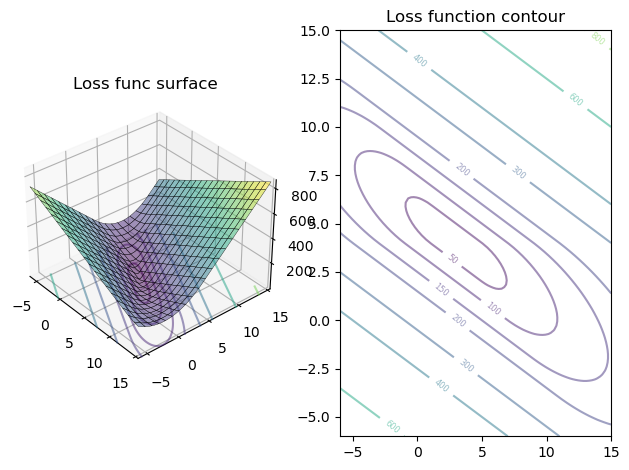

In [102]:
w1_min, w1_max, w2_min, w2_max = -6, 15, -6, 15
w1_mesh, w2_mesh = np.meshgrid(np.linspace(w1_min, w1_max, 100),
                               np.linspace(w2_min, w2_max, 100))
z_mesh = np.apply_along_axis(square_loss,
                             1,
                             np.c_[w1_mesh.ravel(), w2_mesh.ravel()],
                             X_reg.numpy(), y_reg.numpy())
z_mesh = np.reshape(z_mesh, newshape=w1_mesh.shape)

# plotting the surface
ax = plt.subplot(121, projection="3d")
plt.setp(ax, title="Loss func surface", xlim=(w1_min, w2_max), ylim=(w2_min, w2_max))
ax.plot_surface(w1_mesh, w2_mesh, z_mesh, alpha=0.5, lw=0.25, edgecolors="k", cmap="viridis", rstride=5, cstride=5)
ax.view_init(elev=34, azim=-40.0)
ax.contour(w1_mesh, w2_mesh, z_mesh, levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
           cmap="viridis", alpha=0.5, zdir="z", offset=-50)

#  plotting the contour
ax = plt.subplot(122)
plt.setp(ax, title="Loss function contour")
ctr = ax.contour(w1_mesh, w2_mesh, z_mesh, levels=np.array([0,1,50, 100, 150, 200, 300, 400, 600, 800, 1000]),
                 cmap="viridis", alpha=0.5)
ax.clabel(ctr, inline=1, fontsize=6)


plt.tight_layout()
plt.show()

In [103]:
model_linear = nn.Sequential(
    nn.Linear(in_features=1,out_features=1)
)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_linear.parameters(),
                            lr=0.01)

In [104]:
from collections import defaultdict
epochs = 500

history = defaultdict(list)
history["weight"].append([model_linear.state_dict()["0.weight"].item(),model_linear.state_dict()["0.bias"].item()])

for epoch in range(epochs):
    model_linear.train()
    y_pred = model_linear(X_reg)
    loss = loss_fn(y_pred,y_reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history["loss"].append(loss.item())
    history["weight"].append([model_linear.state_dict()["0.weight"].item(),model_linear.state_dict()["0.bias"].item()])


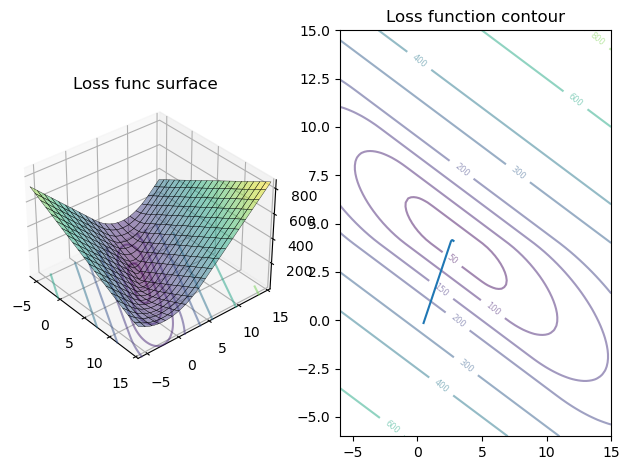

In [105]:
w1_min, w1_max, w2_min, w2_max = -6, 15, -6, 15
w1_mesh, w2_mesh = np.meshgrid(np.linspace(w1_min, w1_max, 100),
                               np.linspace(w2_min, w2_max, 100))
z_mesh = np.apply_along_axis(square_loss,
                             1,
                             np.c_[w1_mesh.ravel(), w2_mesh.ravel()],
                             X_reg.numpy(), y_reg.numpy())
z_mesh = np.reshape(z_mesh, newshape=w1_mesh.shape)

# plotting the surface
ax = plt.subplot(121, projection="3d")
plt.setp(ax, title="Loss func surface", xlim=(w1_min, w2_max), ylim=(w2_min, w2_max))
ax.plot_surface(w1_mesh, w2_mesh, z_mesh, alpha=0.5, lw=0.25, edgecolors="k", cmap="viridis", rstride=5, cstride=5)
ax.view_init(elev=34, azim=-40.0)
ax.contour(w1_mesh, w2_mesh, z_mesh, levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
           cmap="viridis", alpha=0.5, zdir="z", offset=-50)

#  plotting the contour
ax = plt.subplot(122)
plt.setp(ax, title="Loss function contour")
ctr = ax.contour(w1_mesh, w2_mesh, z_mesh, levels=np.array([0,1,50, 100, 150, 200, 300, 400, 600, 800, 1000]),
                 cmap="viridis", alpha=0.5)
ax.clabel(ctr, inline=1, fontsize=6)
plt.plot(path[:,0],path[:,1])

plt.tight_layout()
plt.show()

# Non Linearity

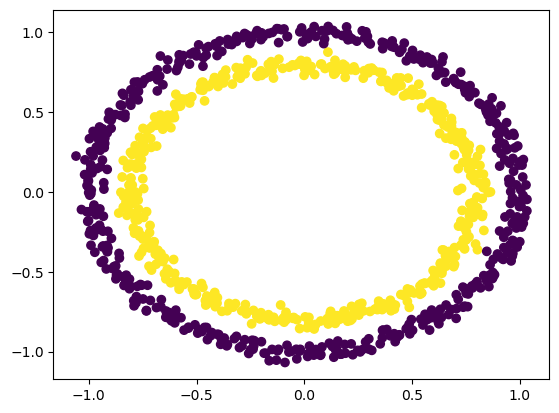

In [107]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y)

In [109]:
# convert the data into tensor and split into train and test set
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Building the model for non Linearity

In [115]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [116]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [117]:
# set up the loss and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

## Training the model

In [118]:
torch.manual_seed(42)
epochs = 1000

# putting all data on target device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(1,epochs+1):
    #### training mode
    model_2.train()

    # 1. forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)

    # 3. set the grad value to zero
    optimizer.zero_grad()

    # 4. back propagate the loss
    loss.backward()

    # 5. update the weights
    optimizer.step()

    #### Testing
    model_2.eval()
    with torch.inference_mode():
        #1 . forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #2. calculate the loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)
     # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 100 | Loss: 0.69117, Accuracy: 53.00% | Test Loss: 0.69104, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68979, Accuracy: 53.37% | Test Loss: 0.68941, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68797, Accuracy: 53.00% | Test Loss: 0.68726, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68520, Accuracy: 52.75% | Test Loss: 0.68415, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68107, Accuracy: 52.75% | Test Loss: 0.67947, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67522, Accuracy: 54.37% | Test Loss: 0.67293, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66670, Accuracy: 58.38% | Test Loss: 0.66333, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65179, Accuracy: 64.00% | Test Loss: 0.64776, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62401, Accuracy: 74.00% | Test Loss: 0.62180, Test Accuracy: 78.50%
Epoch: 1000 | Loss: 0.56891, Accuracy: 87.62% | Test Loss: 0.57440, Test Accuracy: 86.50%


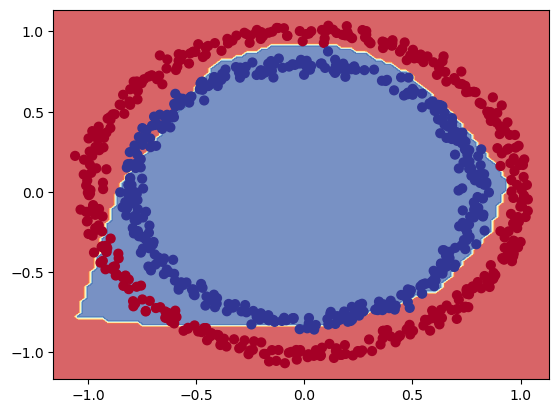

In [119]:
plot_decision_boundary(model_2,X_train,y_train)

# Putting it all together with multi-class classification

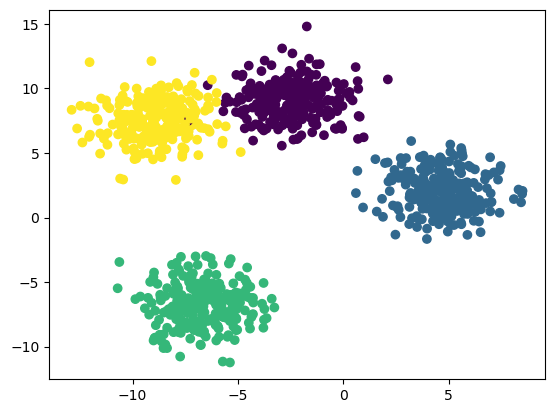

In [141]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set th parameter for data creations
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED =42

# 1. create multi class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

# 2. turn the data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. split into train and test
X_train ,X_test,y_train,y_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED,
                                                  shuffle=True)

# 4. plot the data
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)
plt.show()

## Build the model

In [142]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [183]:
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)



In [184]:
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [185]:
# create the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


## Getting the prediction probability for a multi class

Logits (raw output) --> pred prob (apply the softmax) --> pred labels (argmax)

In [186]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)
y_logits[:4]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388]])

In [187]:
# convert logit to pred prob
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

In [188]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [189]:
# pred prob to pred labels
torch.argmax(y_pred_probs[0])

tensor(3)

In [190]:
y_pred_labels = torch.argmax(y_pred_probs,dim=1)
y_pred_labels

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

## Creating the training loop

In [191]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put the data to device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)


# loop through data
for epoch in range(1,epochs+1):
    #### Training
    model_4.train()

    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if epoch%10 ==0  or epoch ==1:
        print(f"Epoch : {epoch} | Loss : {loss.item():.6f} | Acc : {acc:.2f}% | Test loss: {test_loss:.6f} | Test acc : {test_acc:.2f}%")

Epoch : 1 | Loss : 1.043237 | Acc : 65.50% | Test loss: 0.578615 | Test acc : 95.50%
Epoch : 10 | Loss : 0.157163 | Acc : 99.12% | Test loss: 0.141874 | Test acc : 99.00%
Epoch : 20 | Loss : 0.084033 | Acc : 99.12% | Test loss: 0.075424 | Test acc : 99.50%
Epoch : 30 | Loss : 0.060686 | Acc : 99.12% | Test loss: 0.052769 | Test acc : 99.50%
Epoch : 40 | Loss : 0.049698 | Acc : 99.00% | Test loss: 0.041772 | Test acc : 99.50%
Epoch : 50 | Loss : 0.043429 | Acc : 99.00% | Test loss: 0.035357 | Test acc : 99.50%
Epoch : 60 | Loss : 0.039420 | Acc : 99.00% | Test loss: 0.031174 | Test acc : 99.50%
Epoch : 70 | Loss : 0.036658 | Acc : 99.00% | Test loss: 0.028235 | Test acc : 99.50%
Epoch : 80 | Loss : 0.034651 | Acc : 99.00% | Test loss: 0.026058 | Test acc : 99.50%
Epoch : 90 | Loss : 0.033134 | Acc : 99.12% | Test loss: 0.024379 | Test acc : 99.50%
Epoch : 100 | Loss : 0.031952 | Acc : 99.12% | Test loss: 0.023045 | Test acc : 99.50%


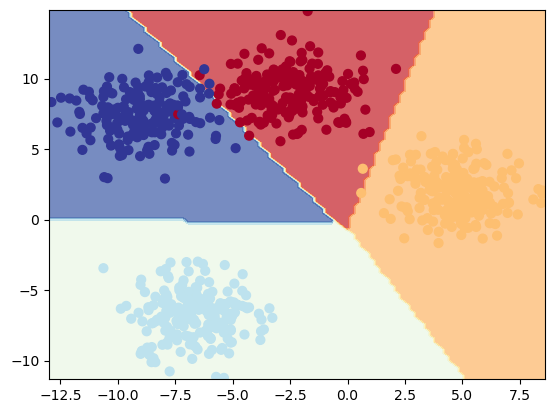

In [192]:
plot_decision_boundary(model_4,X_train,y_train)